# HW #6 Multi- Layer Perceptron

Modified from https://github.com/AgrawalAmey/nnfl-resources

### Computational Intelligence - STRATEGOS UNIGE
#### Names: Armin Baratzade
#### Date 17/Apr/2022

You may prepare a different notebook for each item.

### Part A :
1. For each data set find the minimal NN architecture. You should set the number of layers, the number of neurons for each layer,  the initialization of weights and bias, the dimension of the mini-batchs, the number of iterations, the learning rate. Discuss your results.
2. Plot the learning curve
3. Augment the input layer in order to improve learning (e.g., introduce a new synthetic input as the sum of the squares of the two actual inputs: $z=x^2+y^2$). Discuss your results.

### Part B:  (at least one of the following)
4. Increase the size of your NN and implement weigth decay. Discuss your results.
5. Implement drop-out. Discuss your results.
6. Implement layers normalization. Discuss your results.
7. Implement train with noise. Discuss your results.
8. Change the activation function and its derivative (e.g., try with ReLu). Discuss your results.

**Note:** We are using jdc to define each method a class in separate cells. jdc follows the following syntax:

```py
%%add_to #CLASS_NAME#
def dummy_method(self):
```

In [3]:



# Library imports
import random
import numpy as np
import jdc
import sklearn
import matplotlib.pyplot as plt

In [4]:
from sklearn.datasets import make_circles, make_moons, \
                             make_blobs, make_classification, make_blobs
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

def generate_datsets():
    # ============
    # Generate datasets. We choose the size big enough to see the scalability
    # of the algorithms, but not too big to avoid too long running times
    # ============

    np.random.seed(0)
    
    # >>>
    # n_samples = 1500
    n_samples = 5000

    datasets = {}

    datasets['noisy_circles'] = make_circles(n_samples=n_samples, factor=.5,
                                             noise=.05)
    datasets['noisy_moons'] = make_moons(n_samples=n_samples, noise=.05)
    datasets['blobs'] = make_blobs(n_samples=n_samples, random_state=8)
    datasets['linearly_separable'] = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, 
                                                         n_informative=2, random_state=1, n_clusters_per_class=1)
    # Anisotropicly distributed data
    random_state = 170
    X, y = make_blobs(n_samples=n_samples, random_state=random_state)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    datasets['aniso'] = (X_aniso, y)

    # blobs with varied variances
    datasets['varied'] = make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)
    
    return datasets

def plot_datasets(datasets):
    # ============
    # Set up cluster parameters
    # ============
    plt.figure(figsize=(2.3 * len(datasets) - 0.3, 4.3))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                        hspace=.01)

    dataset_num = 1

    for name, dataset in datasets.items():
        X = dataset[0]
        Ys = dataset[1:]

        # normalize dataset for easier parameter selection
        X = StandardScaler().fit_transform(X)

        flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
        
        for i in range(len(Ys)):
            plt.subplot(2, len(datasets), dataset_num + i * len(datasets))

            if i == 0:
                plt.title(name)

            colors = np.array(list(islice(cycle(flatui), int(max(Ys[i]) + 1))))
            plt.scatter(X[:, 0], X[:, 1], s=5, c=colors[Ys[i]])            
            
            plt.xlim(-2.5, 2.5)
            plt.ylim(-2.5, 2.5)
            plt.xticks(())
            plt.yticks(())

        dataset_num += 1

    plt.show()

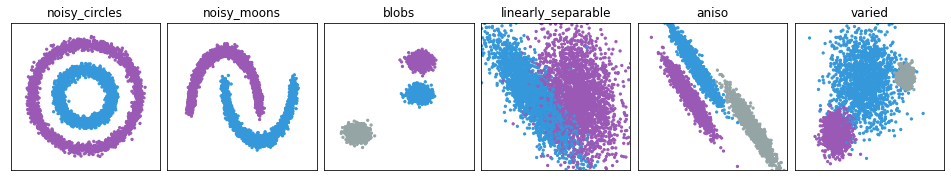

In [5]:
datasets = generate_datsets()

plot_datasets(datasets)

# Multi-Layer Perceptron implementation

We define a generic neural network architecture as a Python class.

In [6]:
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network. For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.initialize_biases()
        self.initialize_weights()

# Initialization

## 3.1.1 Initialize weights and biases

The biases and weights for the network are initialized randomly, using a Gaussian
distribution with mean 0, and variance 1. Note that the first layer is assumed to be an input layer, and by convention we won't set any biases for those neurons, since biases are only ever used in computing the outputs from later layers. Implement the following functions to initialize biases and weights.

**Hints:**
![](https://www.researchgate.net/profile/Michael_Frish/publication/241347660/figure/fig3/AS:298690993508361@1448224890429/Figure-3-The-structure-of-a-multilayer-perceptron-neural-network.png)
- Since we do not define biases for input layer, `len(self.biases)` array is equal to `len(self.sizes) - 1`.
- Every consecutive pair of layers in network have a set of weights connecting them. Hence the `len(self.weights)` would also be `len(self.sizes) - 1` .
- `np.random.randn` picks random variables from  a Gaussian distribution.

In [7]:
%%add_to Network
def initialize_biases(self):
    # >>>
    self.biases = [ np.random.randn(y, 1) for y in self.sizes[1:]]


In [8]:
%%add_to Network
def initialize_weights(self):
    # >>>
    self.weights = [np.random.randn(y, x)
                    for x, y in zip(self.sizes[:-1], self.sizes[1:])]


# Training

We shall implement backpropagation with stochastic mini-batch gradient descent to optimize our network. 

In [9]:
%%add_to Network
def train(self, training_data, epochs, mini_batch_size, learning_rate):
    """Train the neural network using gradient descent.  
    ``training_data`` is a list of tuples ``(x, y)``
    representing the training inputs and the desired
    outputs.  The other parameters are self-explanatory."""

    # training_data is a list and is passed by reference
    # To prevent affecting the original data we use 
    # this hack to create a copy of training_data
    # https://stackoverflow.com/a/2612815
    training_data = list(training_data)
    
    training_data = list(training_data)
    cost_ar = np.zeros(epochs)
    acc_ar = np.zeros(epochs)
    for i in range(epochs):
        # Get mini-batches    
        mini_batches = self.create_mini_batches(training_data, mini_batch_size)

        # Iterate over mini-batches to update parameters   
        cost = sum(map(lambda mini_batch: self.update_params(mini_batch, learning_rate), mini_batches))

        # Find accuracy of the model at the end of epoch         
        acc = self.evaluate(training_data)

        # >>> if ((i//10)*10 ==i):
        print("Epoch {} complete. Total cost: {}, Accuracy: {}".format(i, cost, acc))
        cost_ar[i] = cost
        acc_ar[i] = acc
    return cost_ar, acc_ar

## 3.1.2 Create mini-batches

Split the training data into mini-batches of size `mini_batch_size` and return a list of mini-batches.

In [10]:
%%add_to Network
def create_mini_batches(self, training_data, mini_batch_size):
    # Shuffling data helps a lot in mini-batch SGD
    random.shuffle(training_data)
    
    mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, len(training_data), mini_batch_size)]
    
    return mini_batches

## 3.1.3 Update weights and biases
<img src="https://docs.google.com/drawings/d/e/2PACX-1vQ-BdgJQ_h-W6cvgvdp5Bv_YiC_oMVQ7Tsz6kecQm4SRTE6Zq0HUKbEFCNDtBKNR9-YS_i104TCXPaE/pub?w=601&amp;h=259">



P.S. Alpha is learning rate in case you still didn't get it 


In [11]:
%%add_to Network
def update_params(self, mini_batch, learning_rate):
    """Update the network's weights and biases by applying
    gradient descent using backpropagation."""
    
    # Initialize gradients     
    delta_b = [np.zeros(b.shape) for b in self.biases]
    delta_w = [np.zeros(w.shape) for w in self.weights]
    
    total_cost = 0
    
    for x, y in mini_batch:
        # Obtain the mean squared error and the gradients
        # with resepect to biases and weights        
        cost, del_b, del_w = self.backprop(x, y)
        
        # Add the gradients for each sample in mini-batch        
        delta_b = [nb + dnb for nb, dnb in zip(delta_b, del_b)]
        delta_w = [nw + dnw for nw, dnw in zip(delta_w, del_w)]
        
        total_cost += cost

    # Update self.biases and self.weights
    # using delta_b, delta_w and learning_rate    
    self.biases = [b - (learning_rate / len(mini_batch)) * db
                   for b, db in zip(self.biases, delta_b)]
    self.weights = [w - (learning_rate / len(mini_batch)) * dw
                    for w, dw in zip(self.weights, delta_w)]

    return total_cost

In [12]:
%%add_to Network
def backprop(self, x, y):
    """Return array containing cost, del_b, del_w representing the
    cost function C(x) and gradient for cost function.  ``del_b`` and
    ``del_w`` are layer-by-layer lists of numpy arrays, similar
    to ``self.biases`` and ``self.weights``."""
    # Forward pass
    zs, activations = self.forward(x)
    
    # Backward pass     
    cost, del_b, del_w = self.backward(activations, zs, y)

    return cost, del_b, del_w

## 3.1.5 Activation Functions
Implement functions to calculate sigmoid and it's derivative

In [13]:
%%add_to Network
def sigmoid(self, z):
    """The sigmoid function."""
   
    return 1.0 / (1.0 + np.exp(-z))

In [14]:
%%add_to Network
def sigmoid_derivative(self, z):
    """Derivative of the sigmoid function."""
    
    return self.sigmoid(z) * (1 - self.sigmoid(z))

## 3.1.6 Implement forward propagation

<img src="https://docs.google.com/drawings/d/e/2PACX-1vRu0-T4iRYiif9UAVgEia-fLPd2c0FB4EOO_AiQzLGAU1gBadvscWUpKMG533PTSTXVqcagukcbHOK3/pub?w=656&amp;h=370">

Complete the following function to implement forward propagation

In [15]:
%%add_to Network
def forward(self, x):
    """Compute Z and activation for each layer."""
    
    # list to store all the activations, layer by layer
    zs = []
    
    # current activation
    activation = x
    # list to store all the activations, layer by layer
    activations = [x]
    
    # Loop through each layer to compute activations and Zs    
    for b, w in zip(self.biases, self.weights):
        # YOUR CODE HERE
        # Calculate z
        # watch out for the dimensions of multiplying matrices         
        z = np.dot(w, activation) + b
        zs.append(z)
        # Calculate activation
        activation = self.sigmoid(z)
        activations.append(activation)
        
    return zs, activations

## 3.1.7 Loss Function
Implement functions to calculate mean squared error and  it's derivative

In [16]:
%%add_to Network
def mse(self, output_activations, y):
    """Returns mean square error."""
   
    return sum((output_activations - y) ** 2 / 2)

In [17]:
%%add_to Network
def mse_derivative(self, output_activations, y):
    """Return the vector of partial derivatives \partial C_x /
    \partial a for the output activations. """
   
    return (output_activations - y)

## 3.1.8 Implement backward pass

Refer [this](http://colah.github.io/posts/2015-08-Backprop/) blog by Christopher Olah to understand how gradient computation happens during backward pass.

In [18]:
%%add_to Network
def backward(self, activations, zs, y):
    """Compute and return cost function, gradients for 
    weights and biases for each layer."""
    # Initialize gradient arrays
    del_b = [np.zeros(b.shape) for b in self.biases]
    del_w = [np.zeros(w.shape) for w in self.weights]
    
    # Compute for last layer
    cost = self.mse(activations[-1], y)
    
  
    delta = self.mse_derivative(activations[-1], y) * \
            self.sigmoid_derivative(zs[-1])
    del_b[-1] = delta
    del_w[-1] = np.dot(delta, activations[-2].transpose())
    
    # Loop through each layer in reverse direction to 
    # populate del_b and del_w   
    for l in range(2, self.num_layers):
        z = zs[-l]
        sp = self.sigmoid_derivative(z)
        delta = np.dot(self.weights[-l + 1].transpose(), delta) * sp
        del_b[-l] = delta
        del_w[-l] = np.dot(delta, activations[-l -1].transpose())
    
    return cost, del_b, del_w

In [19]:
%%add_to Network
def evaluate(self, test_data):
    """Return the accuracy of Network. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    test_results = [(np.argmax(self.forward(x)[1][-1]), np.argmax(y))
                    for (x, y) in test_data]
    return sum(int(x == y) for (x, y) in test_results) * 100 / len(test_results)

In [20]:
def crz(X):
    au = np.zeros([len(X),1])
    for i in range(len(X)):
        au[i] = X[i][0]**2 + X[i][1]**2
    au = np.append(X,au,axis=1)
    return au
        

# Showtime

Let's test our implementation on a bunch of datasets.

In [21]:
def pre_process_data(x, y):
    # Find number samples     
    n = len(y)
    # Find number classes
    c  = max(y) + 1
    
    # Normalize the input     
    x = sklearn.preprocessing.normalize(x)

    x = np.split(x, n)
    x = [a.reshape(-1, 1) for a in x]
    
    # Convert lables to one-hot vectors     
    one_hot = np.zeros([n, c])
    one_hot[range(n), y] = 1
    
    y = np.split(one_hot, n)
    y = [a.reshape(-1, 1) for a in y]
    
    return list(zip(x, y))

## 3.1.9 Try out different hyper-parameters

Training dataset: noisy_circles

 Runnung X : 1 - NN : 1


Epoch 0 complete. Total cost: [1408.60930842], Accuracy: 49.96


<string>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Epoch 1 complete. Total cost: [1265.56299915], Accuracy: 49.98
Epoch 2 complete. Total cost: [1259.05878524], Accuracy: 49.96
Epoch 3 complete. Total cost: [1254.84132347], Accuracy: 49.82
Epoch 4 complete. Total cost: [1253.23040692], Accuracy: 49.92
Epoch 5 complete. Total cost: [1252.27522404], Accuracy: 49.92
Epoch 6 complete. Total cost: [1251.09354073], Accuracy: 50.0
Epoch 7 complete. Total cost: [1251.22078802], Accuracy: 50.14
Epoch 8 complete. Total cost: [1250.95846655], Accuracy: 50.0
Epoch 9 complete. Total cost: [1251.27270431], Accuracy: 50.0
Epoch 10 complete. Total cost: [1251.25218563], Accuracy: 49.78
Epoch 11 complete. Total cost: [1250.93473121], Accuracy: 50.0
Epoch 12 complete. Total cost: [1249.92919036], Accuracy: 50.0
Epoch 13 complete. Total cost: [1251.40912273], Accuracy: 49.92
Epoch 14 complete. Total cost: [1251.03322765], Accuracy: 50.0
Epoch 15 complete. Total cost: [1250.75420795], Accuracy: 50.0
Epoch 16 complete. Total cost: [1251.03642169], Accuracy

<string>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Epoch 1 complete. Total cost: [1289.98248174], Accuracy: 43.72
Epoch 2 complete. Total cost: [1277.25433846], Accuracy: 45.62
Epoch 3 complete. Total cost: [1266.41047311], Accuracy: 44.82
Epoch 4 complete. Total cost: [1256.43136483], Accuracy: 49.62
Epoch 5 complete. Total cost: [1247.16494112], Accuracy: 51.34
Epoch 6 complete. Total cost: [1238.16905743], Accuracy: 54.44
Epoch 7 complete. Total cost: [1229.18010757], Accuracy: 56.84
Epoch 8 complete. Total cost: [1218.49712434], Accuracy: 61.76
Epoch 9 complete. Total cost: [1207.50088962], Accuracy: 64.92
Epoch 10 complete. Total cost: [1194.27241129], Accuracy: 66.42
Epoch 11 complete. Total cost: [1180.95504179], Accuracy: 70.4
Epoch 12 complete. Total cost: [1164.43218842], Accuracy: 79.3
Epoch 13 complete. Total cost: [1146.39247319], Accuracy: 86.22
Epoch 14 complete. Total cost: [1125.25446917], Accuracy: 93.74
Epoch 15 complete. Total cost: [1100.89653064], Accuracy: 92.62
Epoch 16 complete. Total cost: [1073.13127139], Acc

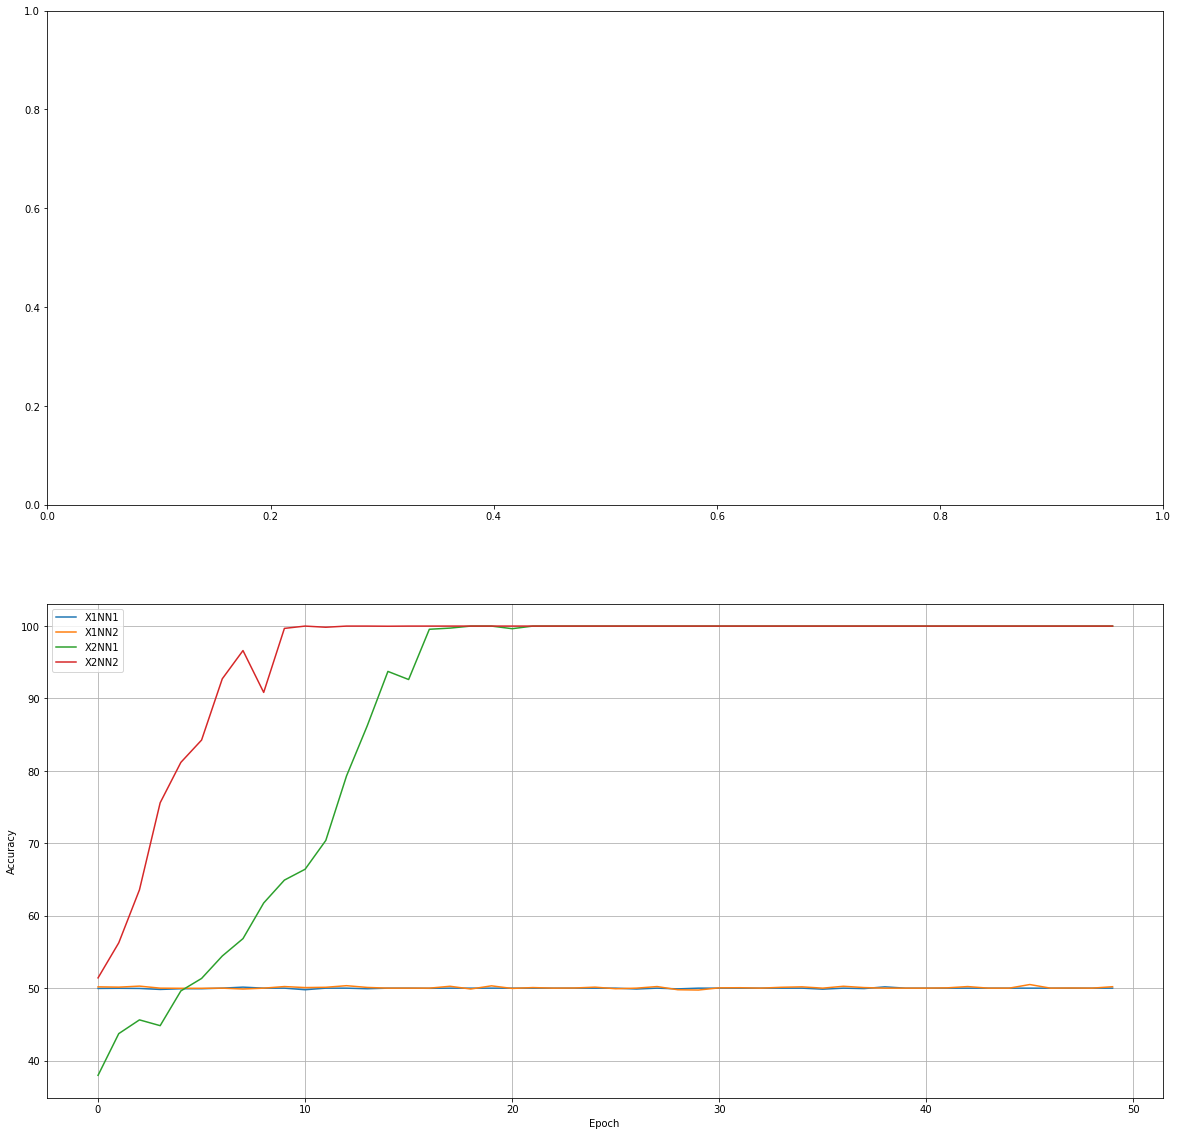

Training dataset: noisy_moons

 Runnung X : 1 - NN : 1
Epoch 0 complete. Total cost: [1167.15157287], Accuracy: 77.34


<string>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Epoch 1 complete. Total cost: [820.7400704], Accuracy: 80.08
Epoch 2 complete. Total cost: [706.54226586], Accuracy: 82.1
Epoch 3 complete. Total cost: [654.62292856], Accuracy: 83.44
Epoch 4 complete. Total cost: [625.26905974], Accuracy: 84.3
Epoch 5 complete. Total cost: [605.80440184], Accuracy: 84.68
Epoch 6 complete. Total cost: [591.56944794], Accuracy: 85.02
Epoch 7 complete. Total cost: [580.5729833], Accuracy: 85.54
Epoch 8 complete. Total cost: [572.24335344], Accuracy: 85.86
Epoch 9 complete. Total cost: [565.31875147], Accuracy: 85.88
Epoch 10 complete. Total cost: [559.69070251], Accuracy: 86.22
Epoch 11 complete. Total cost: [554.94022621], Accuracy: 86.32
Epoch 12 complete. Total cost: [550.92365799], Accuracy: 86.56
Epoch 13 complete. Total cost: [547.47346263], Accuracy: 86.78
Epoch 14 complete. Total cost: [544.47824598], Accuracy: 86.78
Epoch 15 complete. Total cost: [541.83282213], Accuracy: 86.92
Epoch 16 complete. Total cost: [539.55251634], Accuracy: 87.06
Epoch

<string>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Epoch 1 complete. Total cost: [992.74113823], Accuracy: 79.28
Epoch 2 complete. Total cost: [862.9440187], Accuracy: 81.56
Epoch 3 complete. Total cost: [781.9985111], Accuracy: 82.5
Epoch 4 complete. Total cost: [732.63952528], Accuracy: 83.0
Epoch 5 complete. Total cost: [701.06007793], Accuracy: 83.32
Epoch 6 complete. Total cost: [679.44477733], Accuracy: 83.58
Epoch 7 complete. Total cost: [663.47207213], Accuracy: 84.28
Epoch 8 complete. Total cost: [651.08890435], Accuracy: 84.84
Epoch 9 complete. Total cost: [640.76322123], Accuracy: 85.2
Epoch 10 complete. Total cost: [632.04477004], Accuracy: 85.32
Epoch 11 complete. Total cost: [624.42083141], Accuracy: 85.5
Epoch 12 complete. Total cost: [617.80800475], Accuracy: 85.44
Epoch 13 complete. Total cost: [611.86002123], Accuracy: 85.64
Epoch 14 complete. Total cost: [606.35857416], Accuracy: 86.04
Epoch 15 complete. Total cost: [601.25048576], Accuracy: 85.96
Epoch 16 complete. Total cost: [596.90205897], Accuracy: 86.24
Epoch 1

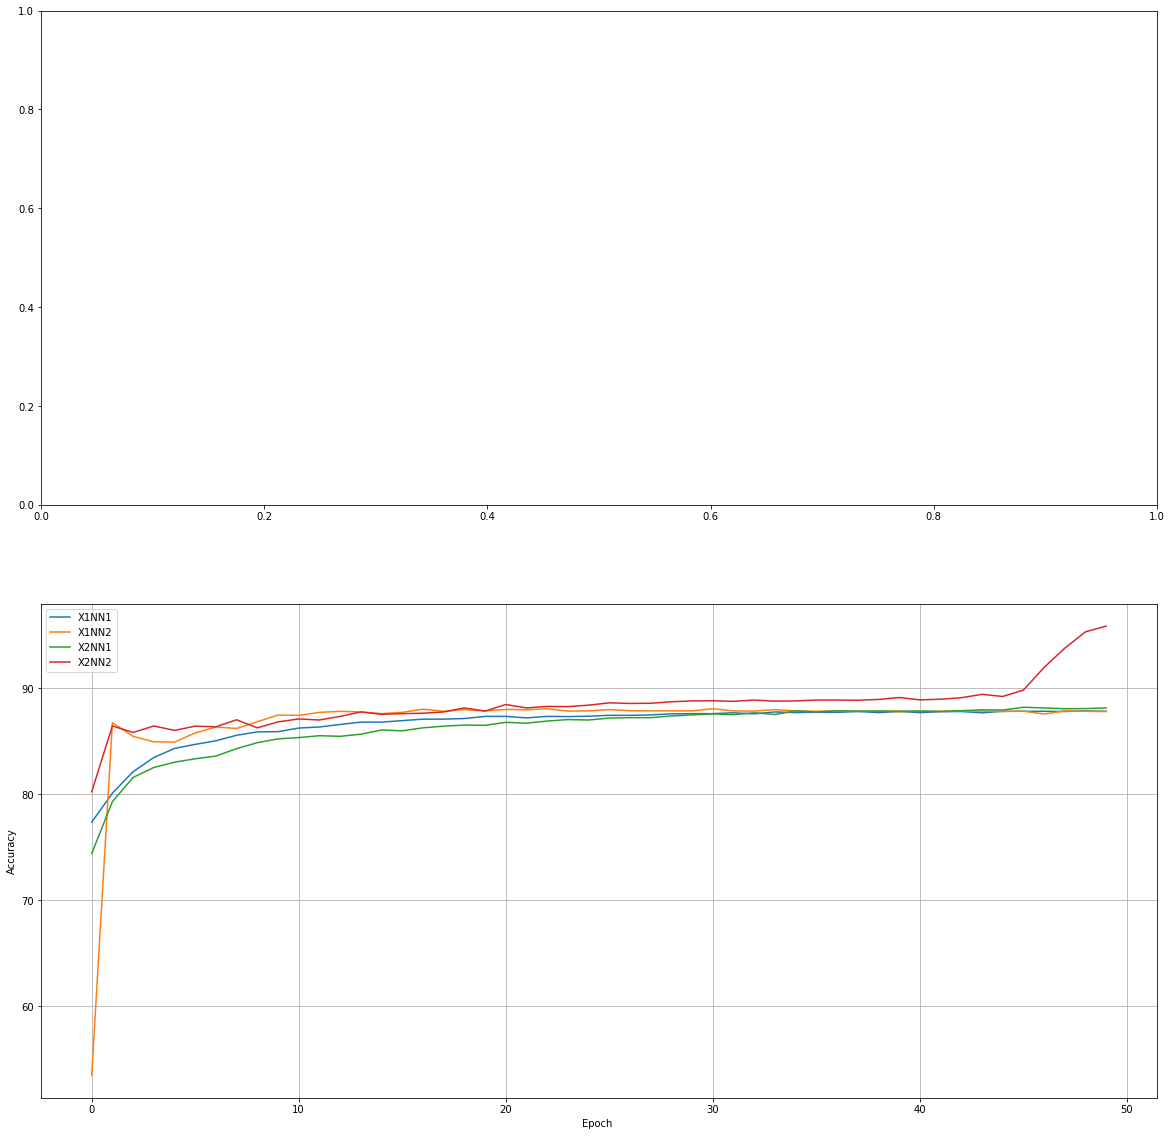

Training dataset: blobs

 Runnung X : 1 - NN : 1
Epoch 0 complete. Total cost: [1363.72042045], Accuracy: 98.52


<string>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Epoch 1 complete. Total cost: [798.66276459], Accuracy: 99.88
Epoch 2 complete. Total cost: [485.78817553], Accuracy: 99.96
Epoch 3 complete. Total cost: [330.57838825], Accuracy: 99.98
Epoch 4 complete. Total cost: [247.62430631], Accuracy: 99.96
Epoch 5 complete. Total cost: [196.40828882], Accuracy: 99.96
Epoch 6 complete. Total cost: [161.54786167], Accuracy: 99.98
Epoch 7 complete. Total cost: [136.31953079], Accuracy: 99.98
Epoch 8 complete. Total cost: [117.32351587], Accuracy: 99.98
Epoch 9 complete. Total cost: [102.57071997], Accuracy: 99.98
Epoch 10 complete. Total cost: [90.85569598], Accuracy: 99.98
Epoch 11 complete. Total cost: [81.3467266], Accuracy: 100.0
Epoch 12 complete. Total cost: [73.51256783], Accuracy: 99.98
Epoch 13 complete. Total cost: [66.94688085], Accuracy: 100.0
Epoch 14 complete. Total cost: [61.40497705], Accuracy: 100.0
Epoch 15 complete. Total cost: [56.6435841], Accuracy: 99.98
Epoch 16 complete. Total cost: [52.55120027], Accuracy: 100.0
Epoch 17 c

<string>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Epoch 1 complete. Total cost: [1637.2752898], Accuracy: 66.66
Epoch 2 complete. Total cost: [1621.60426229], Accuracy: 66.66
Epoch 3 complete. Total cost: [1606.0741548], Accuracy: 66.66
Epoch 4 complete. Total cost: [1589.22436133], Accuracy: 66.66
Epoch 5 complete. Total cost: [1571.25272292], Accuracy: 66.66
Epoch 6 complete. Total cost: [1552.27426341], Accuracy: 73.26
Epoch 7 complete. Total cost: [1532.1025273], Accuracy: 66.66
Epoch 8 complete. Total cost: [1509.9274727], Accuracy: 95.96
Epoch 9 complete. Total cost: [1486.34576719], Accuracy: 99.54
Epoch 10 complete. Total cost: [1460.91472205], Accuracy: 86.58
Epoch 11 complete. Total cost: [1434.52797623], Accuracy: 66.66
Epoch 12 complete. Total cost: [1406.25321947], Accuracy: 96.42
Epoch 13 complete. Total cost: [1376.72999788], Accuracy: 66.66
Epoch 14 complete. Total cost: [1345.17168177], Accuracy: 99.94
Epoch 15 complete. Total cost: [1314.3145751], Accuracy: 66.66
Epoch 16 complete. Total cost: [1281.07684655], Accura

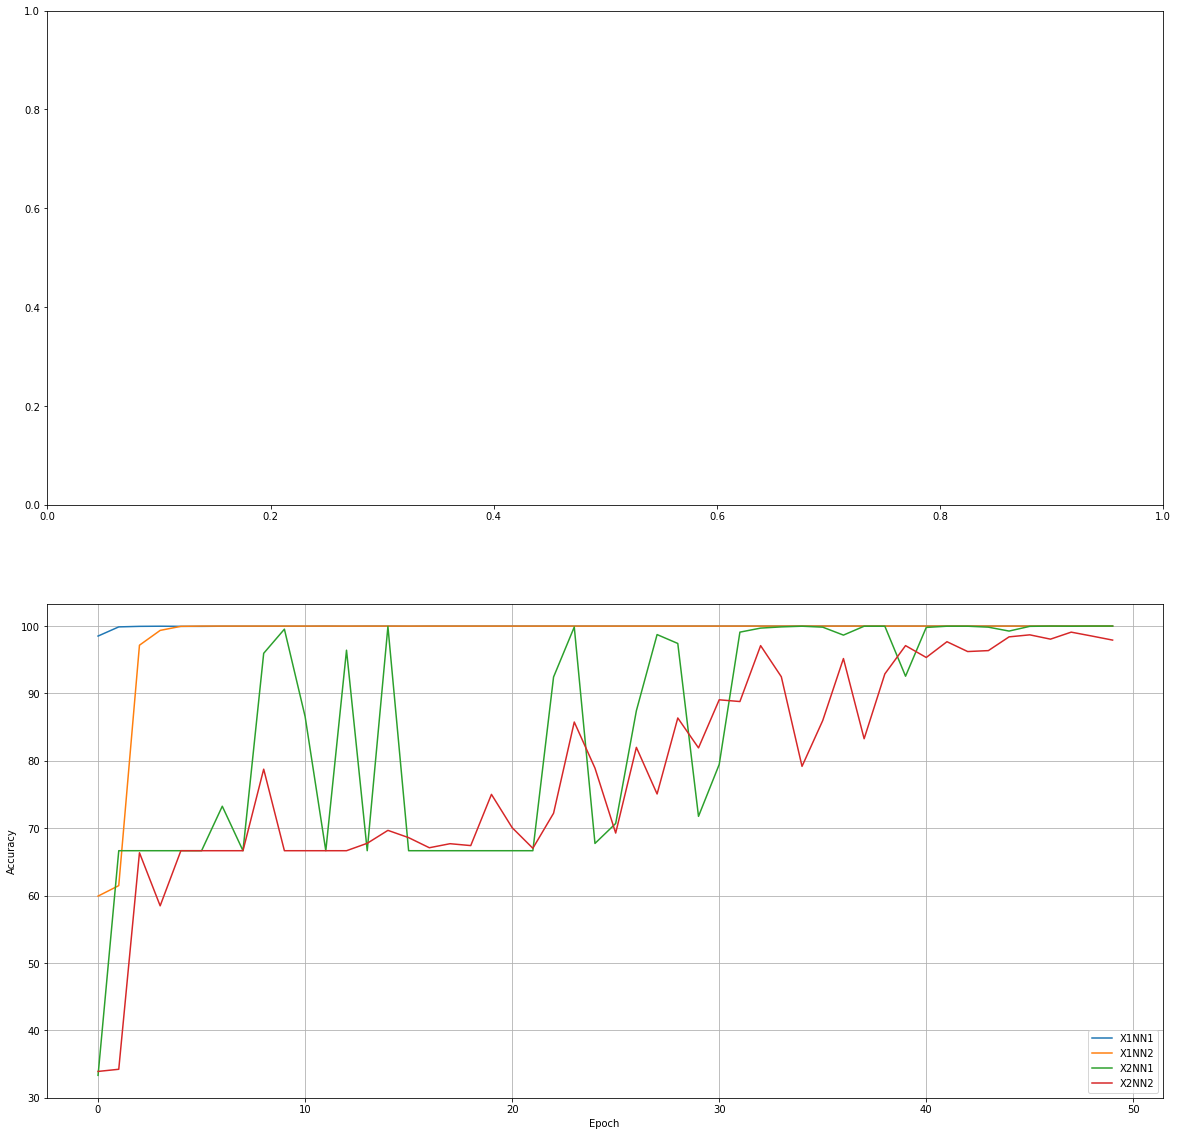

Training dataset: linearly_separable

 Runnung X : 1 - NN : 1
Epoch 0 complete. Total cost: [1690.87231013], Accuracy: 49.9


<string>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Epoch 1 complete. Total cost: [1087.12756069], Accuracy: 85.18
Epoch 2 complete. Total cost: [734.55979509], Accuracy: 86.16
Epoch 3 complete. Total cost: [637.42697501], Accuracy: 86.5
Epoch 4 complete. Total cost: [584.83531123], Accuracy: 86.92
Epoch 5 complete. Total cost: [552.48527486], Accuracy: 87.28
Epoch 6 complete. Total cost: [531.04927609], Accuracy: 87.3
Epoch 7 complete. Total cost: [515.15590577], Accuracy: 87.34
Epoch 8 complete. Total cost: [503.21056869], Accuracy: 87.64
Epoch 9 complete. Total cost: [493.44198631], Accuracy: 87.84
Epoch 10 complete. Total cost: [485.32687905], Accuracy: 87.9
Epoch 11 complete. Total cost: [478.46825024], Accuracy: 87.94
Epoch 12 complete. Total cost: [472.46904947], Accuracy: 87.98
Epoch 13 complete. Total cost: [467.77271822], Accuracy: 88.0
Epoch 14 complete. Total cost: [463.32066714], Accuracy: 88.1
Epoch 15 complete. Total cost: [459.49910476], Accuracy: 88.18
Epoch 16 complete. Total cost: [456.28450809], Accuracy: 88.32
Epoch

<string>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Epoch 1 complete. Total cost: [1097.49796184], Accuracy: 88.18
Epoch 2 complete. Total cost: [979.72053736], Accuracy: 87.78
Epoch 3 complete. Total cost: [880.20718192], Accuracy: 87.72
Epoch 4 complete. Total cost: [802.27182693], Accuracy: 87.68
Epoch 5 complete. Total cost: [743.58469226], Accuracy: 87.36
Epoch 6 complete. Total cost: [700.35463709], Accuracy: 87.68
Epoch 7 complete. Total cost: [668.0037234], Accuracy: 87.62
Epoch 8 complete. Total cost: [643.1395288], Accuracy: 87.58
Epoch 9 complete. Total cost: [623.89009685], Accuracy: 87.76
Epoch 10 complete. Total cost: [608.38119129], Accuracy: 87.72
Epoch 11 complete. Total cost: [595.8726986], Accuracy: 87.82
Epoch 12 complete. Total cost: [585.52258389], Accuracy: 87.78
Epoch 13 complete. Total cost: [576.8689537], Accuracy: 87.84
Epoch 14 complete. Total cost: [569.39347181], Accuracy: 87.78
Epoch 15 complete. Total cost: [562.93770731], Accuracy: 87.88
Epoch 16 complete. Total cost: [557.20959292], Accuracy: 87.92
Epoc

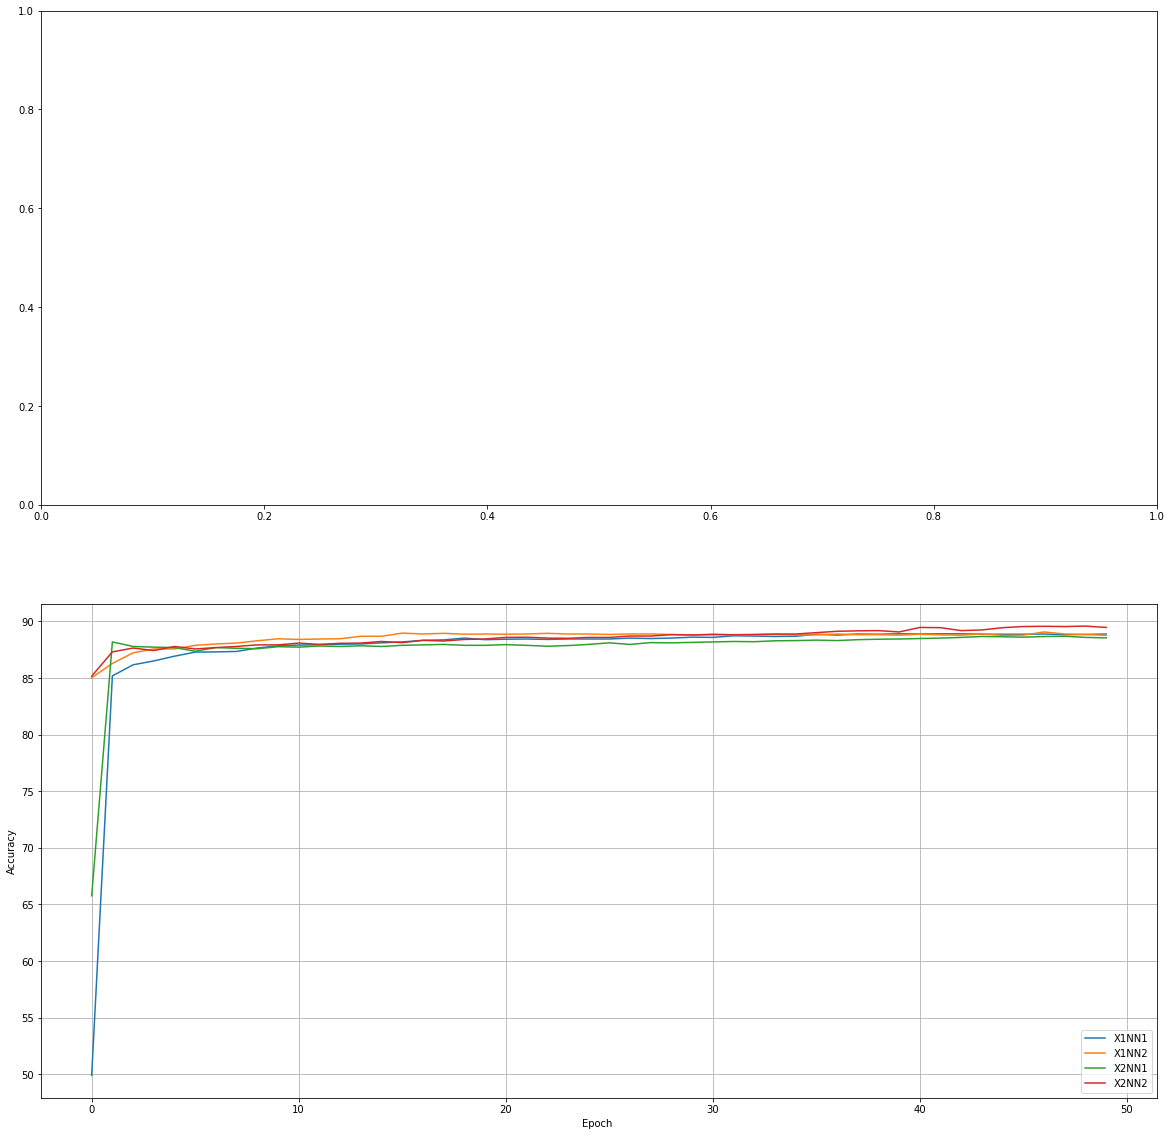

Training dataset: aniso

 Runnung X : 1 - NN : 1
Epoch 0 complete. Total cost: [1719.27375632], Accuracy: 61.58


<string>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Epoch 1 complete. Total cost: [1289.8825652], Accuracy: 61.94
Epoch 2 complete. Total cost: [1113.82400218], Accuracy: 77.96
Epoch 3 complete. Total cost: [993.04886968], Accuracy: 92.14
Epoch 4 complete. Total cost: [910.53949325], Accuracy: 93.72
Epoch 5 complete. Total cost: [844.92591497], Accuracy: 92.14
Epoch 6 complete. Total cost: [786.82141046], Accuracy: 94.08
Epoch 7 complete. Total cost: [732.58745089], Accuracy: 94.22
Epoch 8 complete. Total cost: [681.6451063], Accuracy: 93.5
Epoch 9 complete. Total cost: [635.12677076], Accuracy: 92.96
Epoch 10 complete. Total cost: [593.14825539], Accuracy: 93.4
Epoch 11 complete. Total cost: [556.05050523], Accuracy: 93.78
Epoch 12 complete. Total cost: [523.39118494], Accuracy: 93.44
Epoch 13 complete. Total cost: [494.79648898], Accuracy: 93.88
Epoch 14 complete. Total cost: [469.96100379], Accuracy: 93.6
Epoch 15 complete. Total cost: [448.49398599], Accuracy: 93.84
Epoch 16 complete. Total cost: [429.53678448], Accuracy: 93.98
Epoc

<string>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Epoch 1 complete. Total cost: [1571.78438581], Accuracy: 60.68
Epoch 2 complete. Total cost: [1456.67350551], Accuracy: 61.32
Epoch 3 complete. Total cost: [1354.36109582], Accuracy: 60.94
Epoch 4 complete. Total cost: [1270.98962288], Accuracy: 61.9
Epoch 5 complete. Total cost: [1207.58729079], Accuracy: 62.42
Epoch 6 complete. Total cost: [1159.86848599], Accuracy: 64.3
Epoch 7 complete. Total cost: [1123.42019031], Accuracy: 67.14
Epoch 8 complete. Total cost: [1094.96218576], Accuracy: 89.24
Epoch 9 complete. Total cost: [1072.22177119], Accuracy: 67.24
Epoch 10 complete. Total cost: [1053.98923381], Accuracy: 87.96
Epoch 11 complete. Total cost: [1037.58943619], Accuracy: 72.08
Epoch 12 complete. Total cost: [1024.35783656], Accuracy: 94.66
Epoch 13 complete. Total cost: [1011.32246052], Accuracy: 78.22
Epoch 14 complete. Total cost: [1000.65318963], Accuracy: 91.36
Epoch 15 complete. Total cost: [989.76189747], Accuracy: 92.16
Epoch 16 complete. Total cost: [979.93222061], Accur

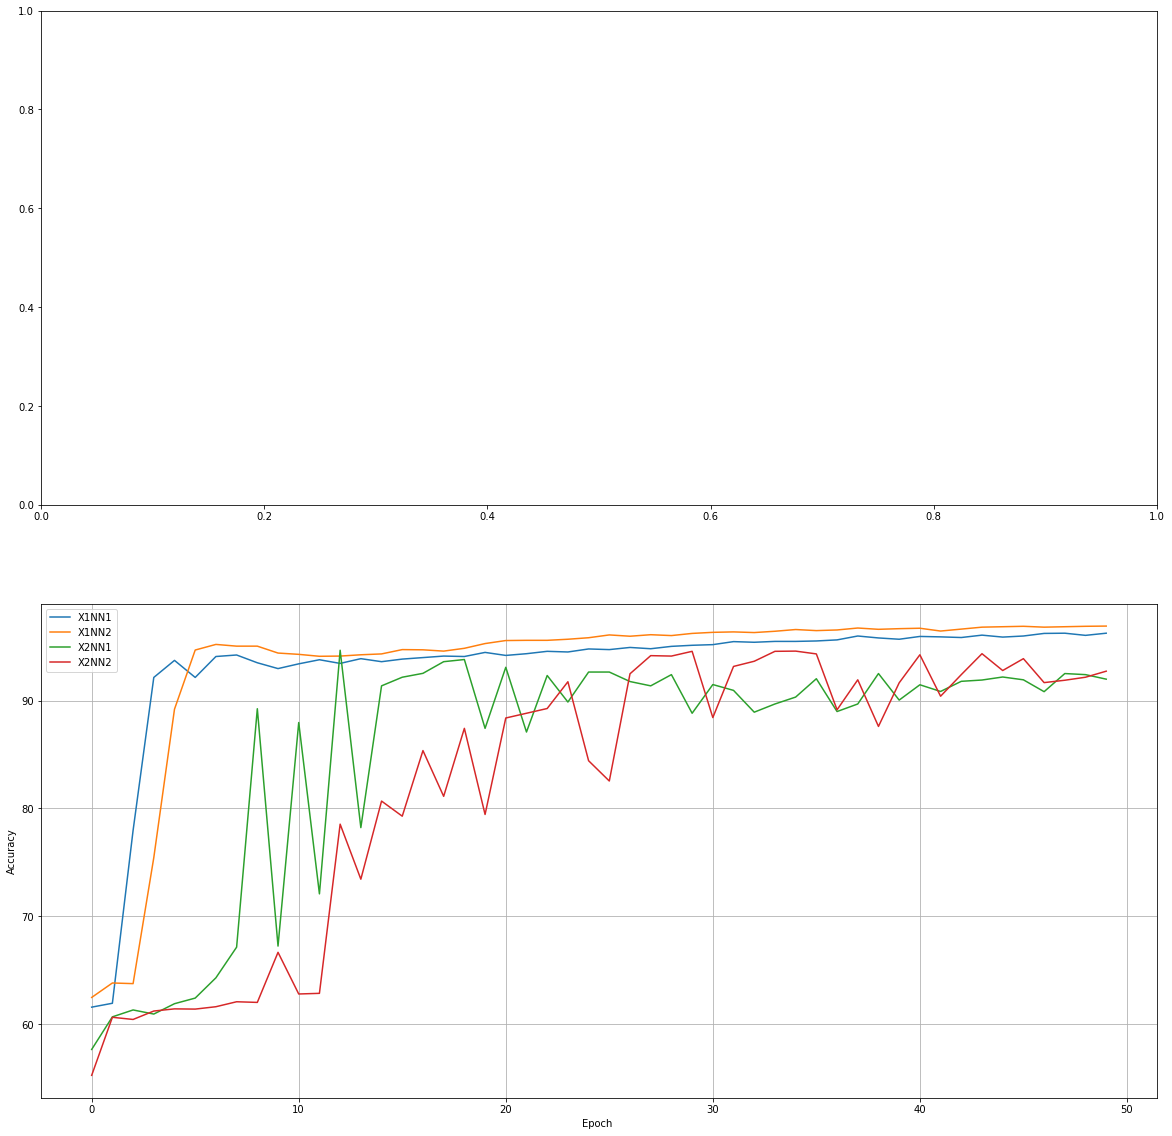

Training dataset: varied

 Runnung X : 1 - NN : 1
Epoch 0 complete. Total cost: [1704.20873679], Accuracy: 49.16


<string>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Epoch 1 complete. Total cost: [1128.22382232], Accuracy: 65.3
Epoch 2 complete. Total cost: [961.64150551], Accuracy: 89.62
Epoch 3 complete. Total cost: [880.94195927], Accuracy: 88.74
Epoch 4 complete. Total cost: [824.12873778], Accuracy: 89.6
Epoch 5 complete. Total cost: [777.19753373], Accuracy: 88.72
Epoch 6 complete. Total cost: [735.57090195], Accuracy: 87.94
Epoch 7 complete. Total cost: [698.25087829], Accuracy: 88.74
Epoch 8 complete. Total cost: [664.90852063], Accuracy: 88.78
Epoch 9 complete. Total cost: [635.8550863], Accuracy: 88.86
Epoch 10 complete. Total cost: [610.49631594], Accuracy: 88.16
Epoch 11 complete. Total cost: [589.190134], Accuracy: 88.62
Epoch 12 complete. Total cost: [570.72947439], Accuracy: 88.88
Epoch 13 complete. Total cost: [554.77044473], Accuracy: 88.84
Epoch 14 complete. Total cost: [541.20518258], Accuracy: 89.24
Epoch 15 complete. Total cost: [529.6909176], Accuracy: 89.38
Epoch 16 complete. Total cost: [519.56452889], Accuracy: 89.44
Epoch 

<string>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Epoch 1 complete. Total cost: [1436.36514182], Accuracy: 43.92
Epoch 2 complete. Total cost: [1249.65837996], Accuracy: 72.0
Epoch 3 complete. Total cost: [1146.97689951], Accuracy: 64.66
Epoch 4 complete. Total cost: [1072.03984082], Accuracy: 65.44
Epoch 5 complete. Total cost: [1019.10222219], Accuracy: 84.94
Epoch 6 complete. Total cost: [981.11829201], Accuracy: 65.08
Epoch 7 complete. Total cost: [952.7010579], Accuracy: 63.9
Epoch 8 complete. Total cost: [931.91933432], Accuracy: 65.24
Epoch 9 complete. Total cost: [915.59079543], Accuracy: 91.46
Epoch 10 complete. Total cost: [902.50390059], Accuracy: 89.1
Epoch 11 complete. Total cost: [891.60589686], Accuracy: 64.88
Epoch 12 complete. Total cost: [882.38175653], Accuracy: 65.12
Epoch 13 complete. Total cost: [874.05861038], Accuracy: 93.66
Epoch 14 complete. Total cost: [867.04343844], Accuracy: 88.18
Epoch 15 complete. Total cost: [860.82670497], Accuracy: 93.94
Epoch 16 complete. Total cost: [854.76952077], Accuracy: 67.6
E

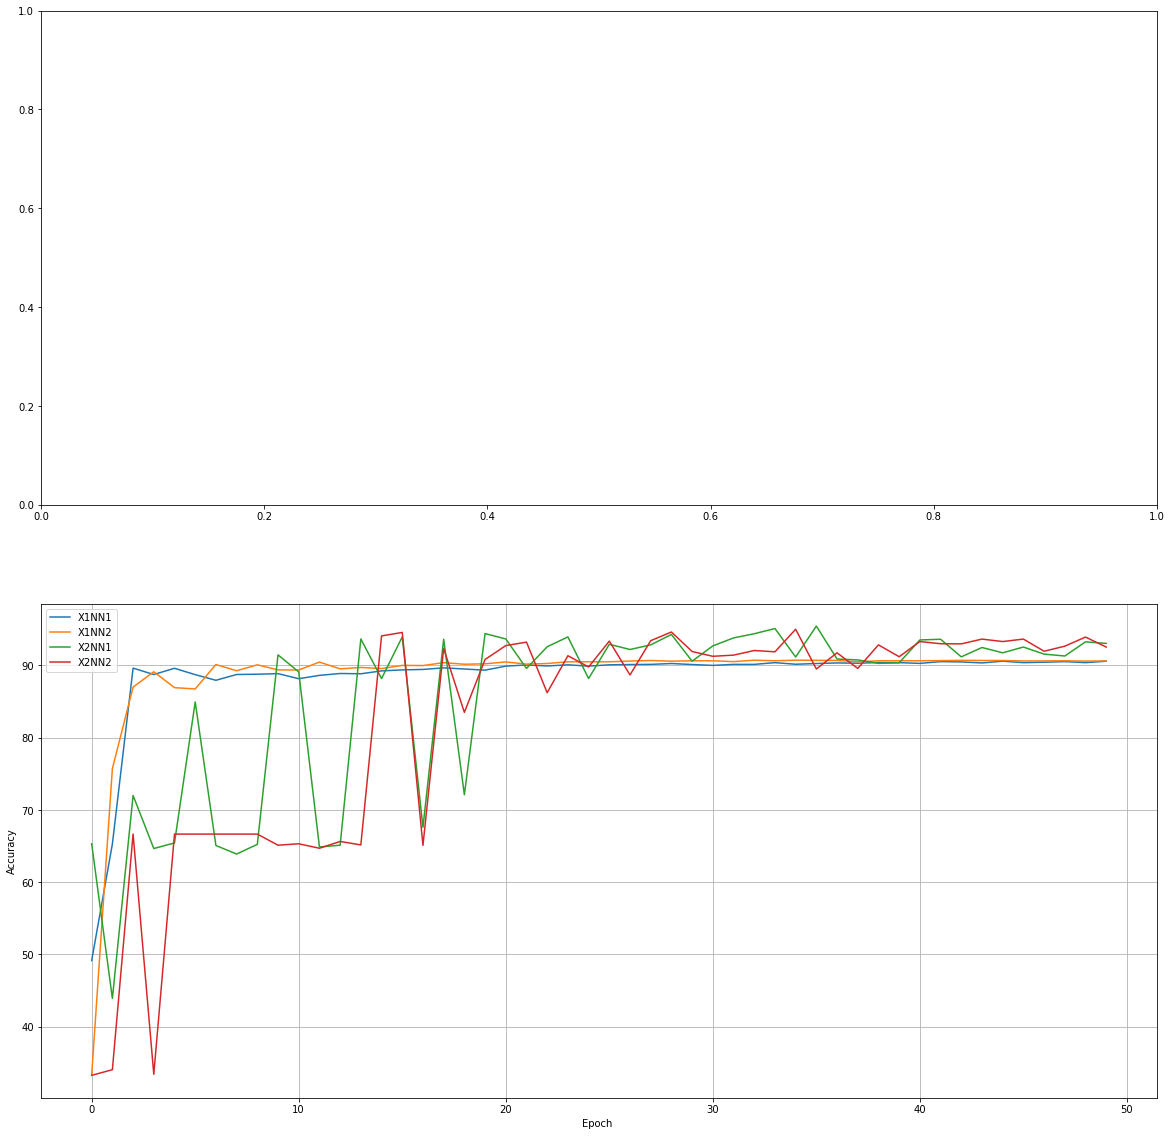

In [22]:
datasets_with_pred = {}

for name, dataset in datasets.items():
    print("Training dataset: {}".format(name))
    coac_list = []
    X1, Y = dataset
    X2 = crz(X1)
    xx = 1
    for X in [X1,X2]:
        # Find number classes
        c  = max(Y) + 1
        # Pre-process the data
        # Checkout the implementation for some cool numpy tricks     
        training_data = pre_process_data(X, Y)
        N1 = [X.shape[1], 7, c]
        N2 = [X.shape[1], 15, 7, c]
        nn = 1
        for N in [N1,N2]:
            print("\n","Runnung X : {} - NN : {}".format(xx,nn))
            network = Network(N)
            #network.train(training_data, 20, 10, 0.1)
            cost_ar, acc_ar = network.train(training_data, 50, 10, 0.05)
            
            coac_list.append([cost_ar, acc_ar,'X'+str(xx)+'NN'+str(nn)])
            predictions = list(map(lambda sample: np.argmax(network.forward(sample[0])[1][-1]), training_data))
            datasets_with_pred[(name,'X'+str(xx)+'NN'+str(nn))] = X, Y, predictions
            nn += 1
        xx += 1
    x = np.arange(0, 50)
    fig, axs = plt.subplots(2)
    for i in coac_list:
        axs[1].plot(x, i[1], label = i[2])
    axs[1].set_xlabel('Epoch ')
    axs[1].set_ylabel('Accuracy')
    axs[1].grid(True)
    axs[1].legend()
    fig.set_figwidth(20)
    fig.set_figheight(20)
    plt.show()

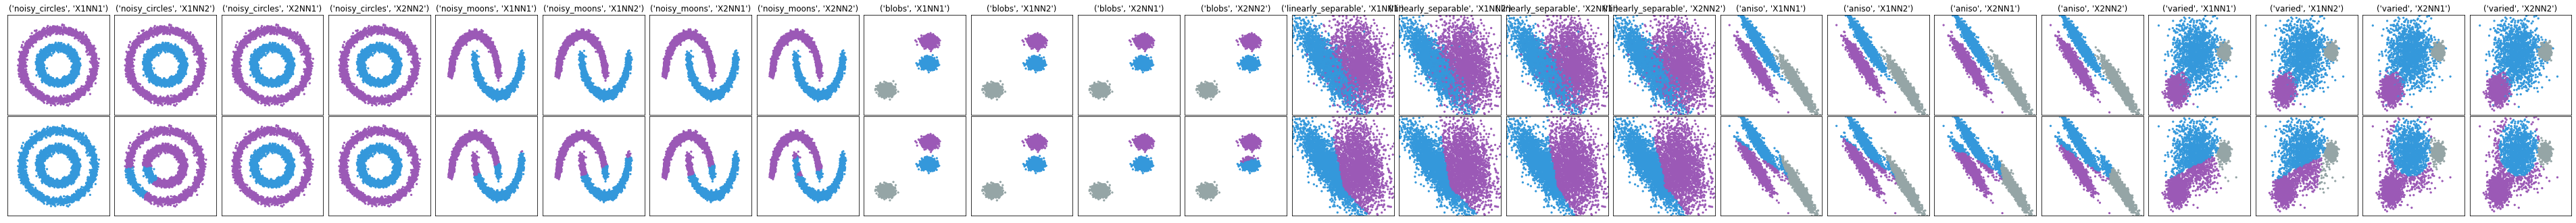

In [23]:
plot_datasets(datasets_with_pred)